In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('kandles.csv')
df_new = pd.read_csv('kandles_new.csv')

In [3]:
def fibonacci_bollinger_bands(df_1, n=20, m=3):  
    # Рассчитать скользящую среднюю и стандартное отклонение:  
    df_1['SMA'] = df_1['close'].rolling(window=n).mean()  
    df_1['SD'] = df_1['close'].rolling(window=n).std()  
    # Вычислить верхнюю и нижнюю полосы:  
    df_1['Верхняя полоса'] = df_1['SMA'] + (df_1['SD'] * m)  
    df_1['Нижняя полоса'] = df_1['SMA'] - (df_1['SD'] * m)  
    return df_1 

In [4]:
df['ma_fast'] = df['close'].ewm(span=12, adjust=False).mean()
df['ma_slow'] = df['close'].ewm(span=26, adjust=False).mean()
df['macd'] = df['ma_fast'] - df['ma_slow']
df['signal'] = df['macd'].ewm(span=9, adjust=False).mean()
df = fibonacci_bollinger_bands(df)
df['high_1'] = df['high'].shift()
df['high_2'] = df['high_1'].shift()
df['high_3'] = df['high_2'].shift()
df['high_4'] = df['high_3'].shift()

In [5]:
df_new['ma_fast'] = df_new['close'].ewm(span=12, adjust=False).mean()
df_new['ma_slow'] = df_new['close'].ewm(span=26, adjust=False).mean()
df_new['macd'] = df_new['ma_fast'] - df_new['ma_slow']
df_new['signal'] = df_new['macd'].ewm(span=9, adjust=False).mean()
df_new = fibonacci_bollinger_bands(df_new)
df_new['high_1'] = df_new['high'].shift()
df_new['high_2'] = df_new['high_1'].shift()
df_new['high_3'] = df_new['high_2'].shift()
df_new['high_4'] = df_new['high_3'].shift()

In [6]:
df.drop(df.head(20).index, inplace=True)
df.drop(df.tail(1).index, inplace=True)
df_new.drop(df_new.head(20).index, inplace=True)
df_new.drop(df_new.tail(1).index, inplace=True)

In [7]:
X = df.drop(columns=['close', 'open_time', 'close_time', 'ignore', 'high', 'low'])
y = df['high']

In [8]:
%%time

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, QuantileTransformer
from sklearn.pipeline import make_pipeline
from sklearn.base import clone
import time
from scipy.stats import loguniform

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Функция для оценки моделей
def evaluate_model(model, X_train, y_train, X_test, y_test):
    start_time = time.time()
    
    # Обучение модели
    model.fit(X_train, y_train)
    
    # Предсказания
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Метрики
    metrics = {
        'MAE_train': mean_absolute_error(y_train, train_pred),
        'MAE_test': mean_absolute_error(y_test, test_pred),
        'RMSE_train': np.sqrt(mean_squared_error(y_train, train_pred)),
        'RMSE_test': np.sqrt(mean_squared_error(y_test, test_pred)),
        'R2_train': r2_score(y_train, train_pred),
        'R2_test': r2_score(y_test, test_pred),
        'Time_sec': time.time() - start_time
    }
    
    return metrics

# Определение базовых моделей с гиперпараметрами
base_models = [
    ('lr', make_pipeline(
        QuantileTransformer(output_distribution='normal'),
        StandardScaler(),
        LinearRegression()
    )),
    ('ridge', make_pipeline(
        StandardScaler(),
        Ridge(alpha=1.0, solver='auto', random_state=42)
    )),
    ('lasso', make_pipeline(
        StandardScaler(),
        Lasso(alpha=0.01, random_state=42, selection='cyclic')
    )),
    ('poly', make_pipeline(
        StandardScaler(),
        PolynomialFeatures(degree=2, include_bias=False, interaction_only=False),
        Ridge(alpha=0.1, solver='auto')
    )),
    ('svr_rbf', make_pipeline(
        StandardScaler(),
        SVR(kernel='rbf', C=1.0, epsilon=0.1)
    )),
    ('rf', RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    )),
    ('gb', GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=4,
        random_state=42
    )),
    ('hgb', HistGradientBoostingRegressor(
        max_iter=200,
        learning_rate=0.05,
        max_depth=4,
        random_state=42,
        early_stopping=True
    ))
]

# Определение мета-модели с настройкой гиперпараметров
meta_model = RandomizedSearchCV(
    Ridge(),
    param_distributions={'alpha': loguniform(1e-3, 1e3)},
    n_iter=50,
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Создание стекингового регрессора
stacking_model_high = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=True,  # Добавляем оригинальные признаки к мета-признакам
    verbose=1
)

# Оценка стекинговой модели
stacking_metrics = evaluate_model(stacking_model_high, X_train, y_train, X_test, y_test)

# Вывод результатов
print("\nStacking Model Performance:")
for k, v in stacking_metrics.items():
    print(f"{k:<15}: {v:.4f}" if isinstance(v, float) else f"{k:<15}: {v}")

# Сравнение с базовыми моделями
print("\nBase Models Performance:")
results = []
for name, model in base_models:
    metrics = evaluate_model(clone(model), X_train, y_train, X_test, y_test)
    results.append((name, metrics))
    
    print(f"\n{name.upper()} Performance:")
    for k, v in metrics.items():
        print(f"{k:<15}: {v:.4f}" if isinstance(v, float) else f"{k:<15}: {v}")

# Создание DataFrame для сравнения результатов
results_df = pd.DataFrame({
    'Model': ['Stacking'] + [name for name, _ in base_models],
    'MAE_test': [stacking_metrics['MAE_test']] + [metrics['MAE_test'] for _, metrics in results],
    'RMSE_test': [stacking_metrics['RMSE_test']] + [metrics['RMSE_test'] for _, metrics in results],
    'R2_test': [stacking_metrics['R2_test']] + [metrics['R2_test'] for _, metrics in results],
    'Time_sec': [stacking_metrics['Time_sec']] + [metrics['Time_sec'] for _, metrics in results]
}).sort_values(by='MAE_test')

print("\nModels ranked by MAE_test:")
print(results_df)

C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.78554e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Stacking Model Performance:
MAE_train      : 59.9744
MAE_test       : 66.7324
RMSE_train     : 95.2084
RMSE_test      : 112.2508
R2_train       : 1.0000
R2_test        : 1.0000
Time_sec       : 673.3944

Base Models Performance:

LR Performance:
MAE_train      : 4845.3825
MAE_test       : 4932.4707
RMSE_train     : 6474.7543
RMSE_test      : 6596.3134
R2_train       : 0.9360
R2_test        : 0.9334
Time_sec       : 0.5540

RIDGE Performance:
MAE_train      : 84.7850
MAE_test       : 84.7878
RMSE_train     : 134.9590
RMSE_test      : 134.3135
R2_train       : 1.0000
R2_test        : 1.0000
Time_sec       : 0.0520

LASSO Performance:
MAE_train      : 101.7066
MAE_test       : 103.7546
RMSE_train     : 169.4263
RMSE_test      : 170.7080
R2_train       : 1.0000
R2_test        : 1.0000
Time_sec       : 0.4600

POLY Performance:
MAE_train      : 65.8952
MAE_test       : 67.6142
RMSE_train     : 104.4389
RMSE_test      : 113.5246
R2_train       : 1.0000
R2_test        : 1.0000
Time_sec      

In [9]:
X_new = df_new.drop(columns=['close', 'open_time', 'close_time', 'ignore', 'high', 'low'])

In [14]:
X_new

,open,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ma_fast,ma_slow,macd,signal,SMA,SD,Верхняя полоса,Нижняя полоса,high_1,high_2,high_3,high_4
20,102820.01,829.79334,8.531549e+07,195675,428.33903,4.404245e+07,102011.382846,100935.093623,1076.289223,833.378649,100912.5255,1550.788708,105564.891625,96260.159375,103268.44,103301.60,103230.66,104145.76
21,103098.34,1049.12723,1.078088e+08,123501,559.50892,5.748563e+07,102101.247024,101058.086688,1043.160335,875.334987,101090.3010,1528.464970,105675.695911,96504.906089,103128.00,103268.44,103301.60,103230.66
22,102595.50,887.20651,9.098281e+07,128465,383.43020,3.932054e+07,102155.061328,101161.268415,993.792912,899.026572,101250.2360,1492.962862,105729.124587,96771.347413,103098.34,103128.00,103268.44,103301.60
23,102451.04,702.47394,7.207757e+07,93563,346.03887,3.550798e+07,102258.590354,101284.730014,973.860340,913.993325,101408.3030,1483.802846,105859.711537,96956.894463,102800.69,103098.34,103128.00,103268.44
24,102828.01,712.49562,7.327098e+07,87221,422.67035,4.347514e+07,102369.476454,101410.257420,959.219033,923.038467,101567.7220,1472.124871,105984.096614,97151.347386,102852.00,102800.69,103098.34,103128.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,104619.87,869.24120,9.096173e+07,239289,404.03078,4.229401e+07,104730.563688,104972.379722,-241.816034,-287.453501,104764.6895,340.223370,105785.359611,103744.019389,105325.83,104550.92,104908.49,104858.80
995,104801.01,509.29545,5.323306e+07,154657,254.26752,2.657671e+07,104683.850813,104931.976039,-248.125226,-279.587846,104767.9165,336.492372,105777.393617,103758.439383,104973.79,105325.83,104550.92,104908.49
996,104426.93,918.22252,9.553437e+07,205658,406.14794,4.226799e+07,104629.693764,104887.520776,-257.827012,-275.235679,104756.8790,347.372113,105798.995340,103714.762660,104836.64,104973.79,105325.83,104550.92
997,104332.00,1023.78410,1.066882e+08,398958,484.88426,5.053729e+07,104474.877801,104793.881460,-319.003659,-283.989275,104726.6330,415.476646,105973.062939,103480.203061,104508.00,104836.64,104973.79,105325.83


In [16]:
df.head(30)

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,...,macd,signal,SMA,SD,Верхняя полоса,Нижняя полоса,high_1,high_2,high_3,high_4
20,2019-07-27 00:00:00,9824.00,10161.40,9815.00,10142.18,6213.873797,2019-07-27 00:59:59.999,6.262702e+07,42702,3439.364841,...,44.583012,22.266247,9801.6995,86.550352,10061.350556,9542.048444,9845.00,9821.32,9837.20,9860.00
21,2019-07-27 01:00:00,10142.18,10188.66,10086.59,10086.80,2487.997991,2019-07-27 01:59:59.999,2.519045e+07,18733,1316.457970,...,60.117696,29.836537,9819.9920,105.231026,10135.685078,9504.298922,10161.40,9845.00,9821.32,9837.20
22,2019-07-27 02:00:00,10086.80,10110.56,10070.67,10107.91,839.082856,2019-07-27 02:59:59.999,8.467886e+06,11390,418.403792,...,73.287632,38.526756,9840.3875,119.335214,10198.393143,9482.381857,10188.66,10161.40,9845.00,9821.32
23,2019-07-27 03:00:00,10105.77,10119.25,10092.09,10103.00,505.081599,2019-07-27 03:59:59.999,5.104305e+06,8414,249.156015,...,82.379090,47.297223,9857.3195,131.394998,10251.504495,9463.134505,10110.56,10188.66,10161.40,9845.00
24,2019-07-27 04:00:00,10103.02,10118.55,10082.00,10107.27,629.353018,2019-07-27 04:59:59.999,6.356754e+06,8305,371.399646,...,88.903861,55.618550,9873.1075,141.642138,10298.033913,9448.181087,10119.25,10110.56,10188.66,10161.40
25,2019-07-27 05:00:00,10107.27,10110.80,10030.96,10054.82,992.739968,2019-07-27 05:59:59.999,9.994648e+06,10519,508.617830,...,88.818666,62.258574,9886.2735,145.833392,10323.773676,9448.773324,10118.55,10119.25,10110.56,10188.66
26,2019-07-27 06:00:00,10053.86,10077.87,10050.00,10051.70,627.176450,2019-07-27 06:59:59.999,6.311052e+06,8101,352.650114,...,87.490851,67.305029,9900.5120,147.460707,10342.894122,9458.129878,10110.80,10118.55,10119.25,10110.56
27,2019-07-27 07:00:00,10051.70,10076.69,10025.16,10055.33,882.216770,2019-07-27 07:59:59.999,8.868398e+06,10899,476.794452,...,85.743065,70.992636,9913.6965,148.994423,10360.679769,9466.713231,10077.87,10110.80,10118.55,10119.25
28,2019-07-27 08:00:00,10057.32,10088.00,10036.18,10059.48,754.086552,2019-07-27 08:59:59.999,7.589674e+06,9727,388.004738,...,83.727643,73.539638,9927.9865,148.563570,10373.677209,9482.295791,10076.69,10077.87,10110.80,10118.55
29,2019-07-27 09:00:00,10058.25,10072.51,10044.38,10047.98,551.189627,2019-07-27 09:59:59.999,5.543463e+06,6840,247.061551,...,80.277068,74.887124,9941.8725,146.002149,10379.878947,9503.866053,10088.00,10076.69,10077.87,10110.80


In [10]:
result_list = []
stacking_model_high.fit(X, y)
for i in range(977):
    last_data = X_new.iloc[[i]]    
    next_period_price = stacking_model_high.predict(last_data)
    result_list.append(next_period_price)

In [11]:
df_new.drop(df_new.head(1).index, inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_9348\769950361.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


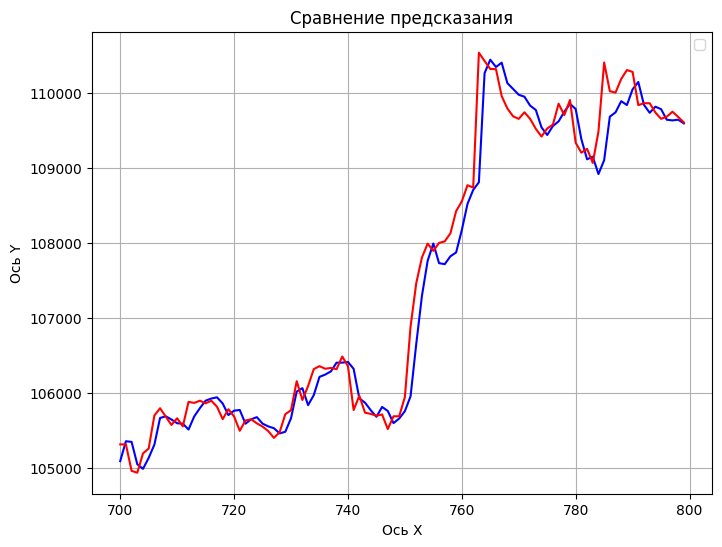

In [13]:
import matplotlib.pyplot as plt


x = range(700, 800)
plt.figure(figsize=(8, 6))  # Размер графика
plt.plot(x, result_list[700:800], color='blue')   # Первая прямая
plt.plot(x, df_new.high[700:800], color='red')    # Вторая прямая

# Добавляем заголовок и подписи осей
plt.title('Сравнение предсказания')
plt.xlabel('Ось X')
plt.ylabel('Ось Y')

# Включаем легенду и сетку
plt.legend()
plt.grid(True)

# Отображаем график
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_9348\1217934942.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


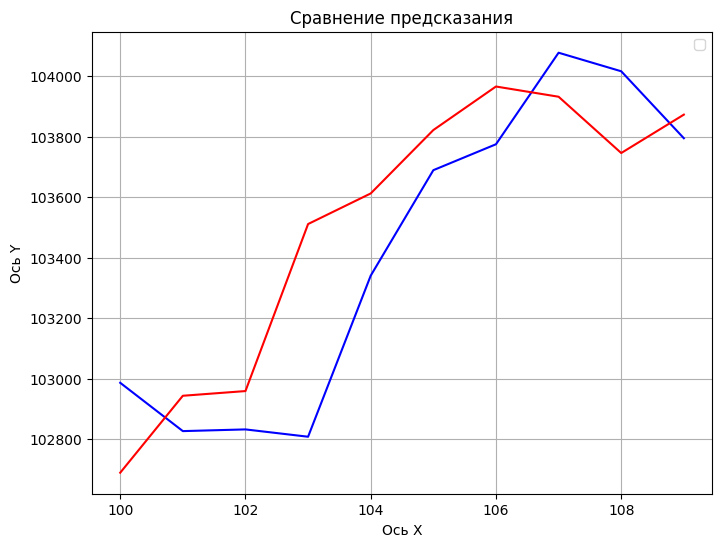

In [12]:
import matplotlib.pyplot as plt


x = range(100, 110)
plt.figure(figsize=(8, 6))  # Размер графика
plt.plot(x, result_list[100:110], color='blue')   # Первая прямая
plt.plot(x, df_new.high[100:110], color='red')    # Вторая прямая

# Добавляем заголовок и подписи осей
plt.title('Сравнение предсказания')
plt.xlabel('Ось X')
plt.ylabel('Ось Y')

# Включаем легенду и сетку
plt.legend()
plt.grid(True)

# Отображаем график
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_21688\1217934942.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


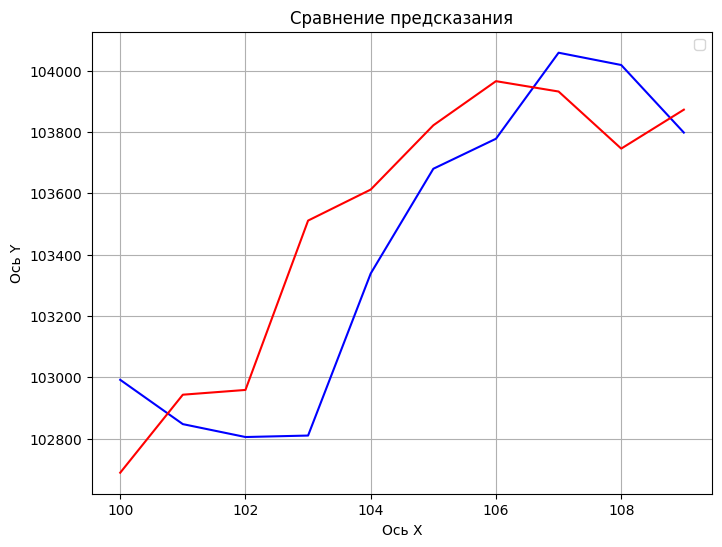

In [24]:
import matplotlib.pyplot as plt


x = range(100, 110)
plt.figure(figsize=(8, 6))  # Размер графика
plt.plot(x, result_list[100:110], color='blue')   # Первая прямая
plt.plot(x, df_new.high[100:110], color='red')    # Вторая прямая

# Добавляем заголовок и подписи осей
plt.title('Сравнение предсказания')
plt.xlabel('Ось X')
plt.ylabel('Ось Y')

# Включаем легенду и сетку
plt.legend()
plt.grid(True)

# Отображаем график
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_21688\1769558840.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


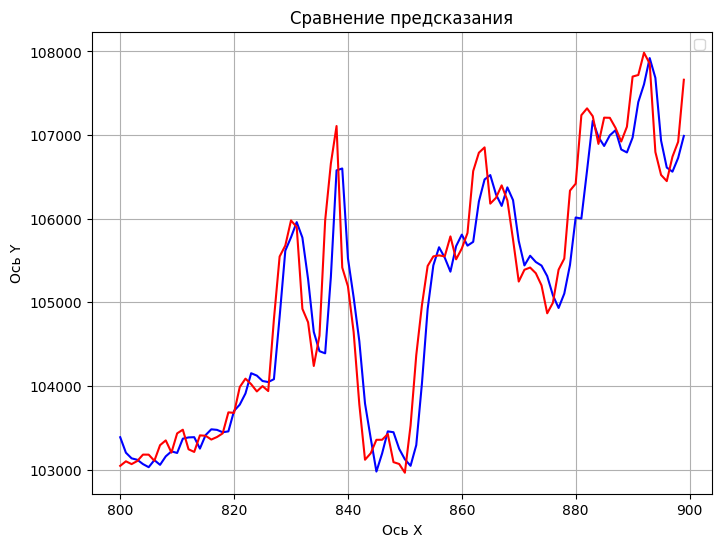

In [19]:
import matplotlib.pyplot as plt


x = range(800, 900)
plt.figure(figsize=(8, 6))  # Размер графика
plt.plot(x, result_list[200:300], color='blue')   # Первая прямая
plt.plot(x, df_new.high[200:300], color='red')    # Вторая прямая

# Добавляем заголовок и подписи осей
plt.title('Сравнение предсказания')
plt.xlabel('Ось X')
plt.ylabel('Ось Y')

# Включаем легенду и сетку
plt.legend()
plt.grid(True)

# Отображаем график
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_21688\899116496.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


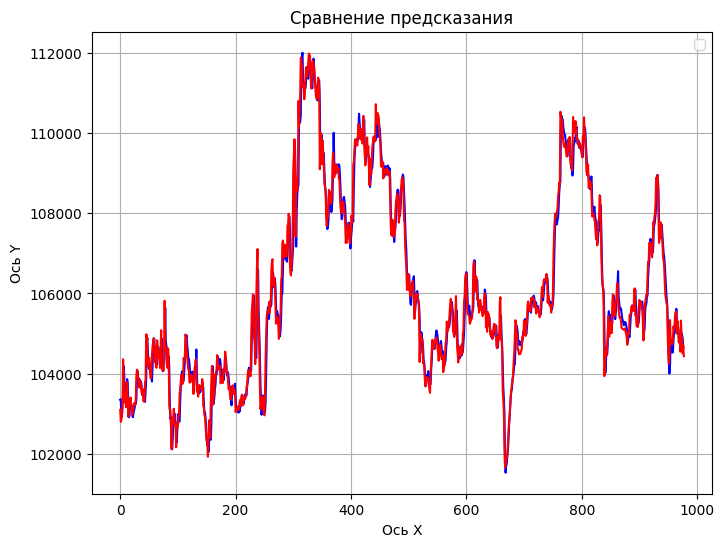

In [21]:
import matplotlib.pyplot as plt


x1 = range(977)
x2 = range(len(df_new))
plt.figure(figsize=(8, 6))  # Размер графика
plt.plot(x1, result_list, color='blue')   # Первая прямая
plt.plot(x2, df_new.high, color='red')    # Вторая прямая

# Добавляем заголовок и подписи осей
plt.title('Сравнение предсказания')
plt.xlabel('Ось X')
plt.ylabel('Ось Y')

# Включаем легенду и сетку
plt.legend()
plt.grid(True)

# Отображаем график
plt.show()